In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import math
from typing import Optional, List
from sortedcontainers import SortedDict
from Plasma import Plasma_Evolver
import itertools

import matplotlib.cm as cm

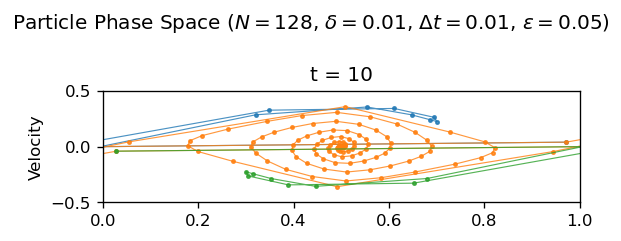

In [17]:
N = 128
dt = 0.01
driver = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0.01, insertion=False, rk = True)


tmax = 10

driver.evolve_plasma(tmax)

driver.plot_particles((-1,), periods=1)
#driver.plot_particles(zoom=True)

#driver.makeMovie(tmax, "test.mp4")


#a = [p.vel_hist[1] for p in driver.plasma.values()]

#driver.plot_particles((15, 20), periods=1)

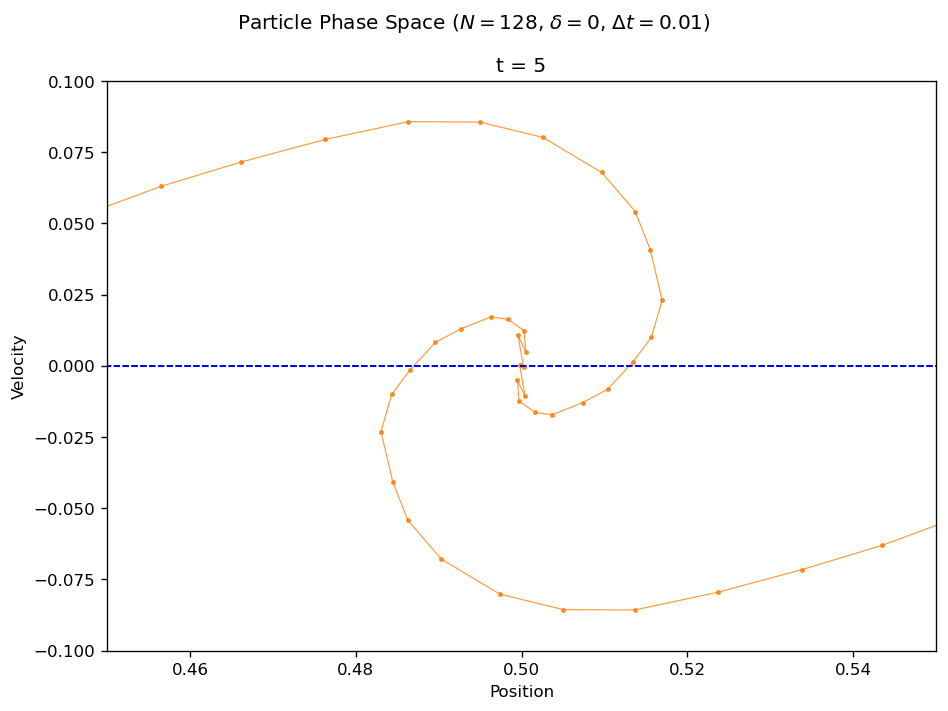

In [ ]:
N = 128
dt = 0.01
driver = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0, insertion=False, rk = True)

tmax = 5

driver.evolve_plasma(tmax)
driver.plot_particles(zoom=True)

1.87
0.9998345874316752


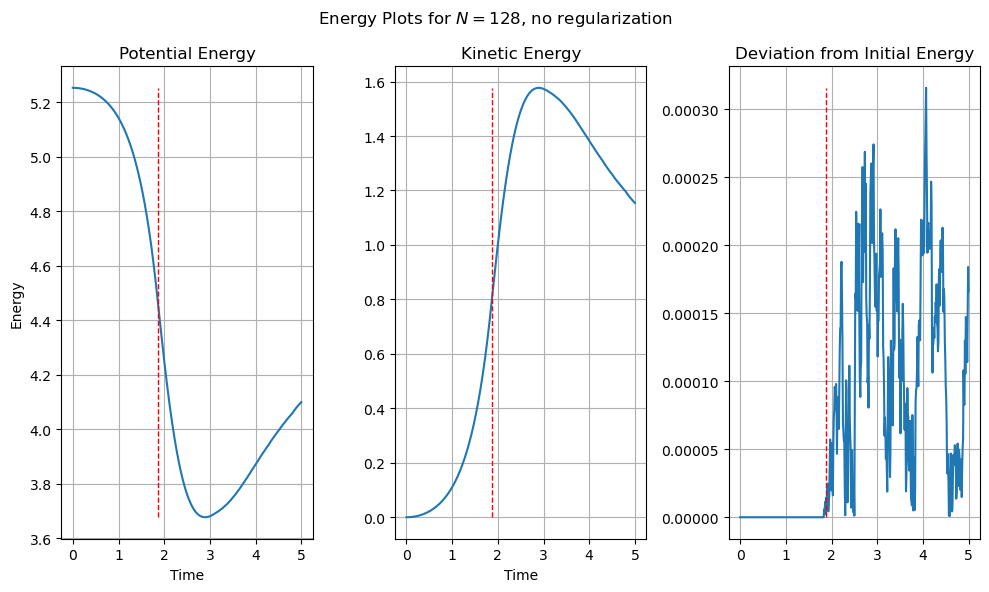

In [ ]:
t = np.arange(0, tmax + 0.01, 0.01)


E0 = (driver.Ek_hist[0] + driver.Ep_hist[0])
E_net = np.array(driver.Ek_hist) + np.array(driver.Ep_hist)

E_error = np.abs(E_net - E0)

ind = np.argmax(np.gradient(driver.Ek_hist))

print(t[ind])

fig, axs = plt.subplots(1,3, figsize=(10,6))

fig.suptitle(r"Energy Plots for $N = {}$, no regularization".format(N))

axs[0].plot(t, np.array(driver.Ep_hist))
axs[0].set_xlabel("Time")
axs[0].set_title("Potential Energy")
axs[0].set_ylabel("Energy")
axs[0].grid()
axs[0].vlines(t[ind], np.min(driver.Ep_hist), np.max(driver.Ep_hist), color='red', linestyle='--', linewidth=1)
axs[1].plot(t, driver.Ek_hist)
axs[1].set_xlabel("Time")
axs[1].set_title("Kinetic Energy")
axs[1].grid()
axs[1].vlines(t[ind], np.min(driver.Ek_hist), np.max(driver.Ek_hist), color='red', linestyle='--', linewidth=1)
axs[2].plot(t, E_error)
axs[2].set_title("Deviation from Initial Energy")
axs[2].grid()
axs[2].vlines(t[ind], np.min(E_error), np.max(E_error), color='red', linestyle='--', linewidth=1)

fig.tight_layout()

print((np.max(driver.Ep_hist) - np.min(driver.Ep_hist)) / (np.max(driver.Ek_hist) - np.min(driver.Ek_hist)))

In [ ]:
dts = np.logspace(-1, -5, 5, base=2)
#dts.append(0.01)
N = 128
tmax = 4
print(dts)

euler_plasmas = []
rk4_plasmas = []

for dt in dts:
    euler_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0, insertion=False, rk = False)
    rk4_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0, insertion=False, rk = True)
    euler_model.evolve_plasma(tmax)
    rk4_model.evolve_plasma(tmax)
    euler_plasmas.append(euler_model)
    rk4_plasmas.append(rk4_model)


[0.5     0.25    0.125   0.0625  0.03125]


In [ ]:
reg_euler_plasmas = []
reg_rk4_plasmas = []

for dt in dts:
    euler_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0.1, insertion=False, rk = False)
    rk4_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0.1, insertion=False, rk = True)
    euler_model.evolve_plasma(tmax)
    rk4_model.evolve_plasma(tmax)
    reg_euler_plasmas.append(euler_model)
    reg_rk4_plasmas.append(rk4_model)

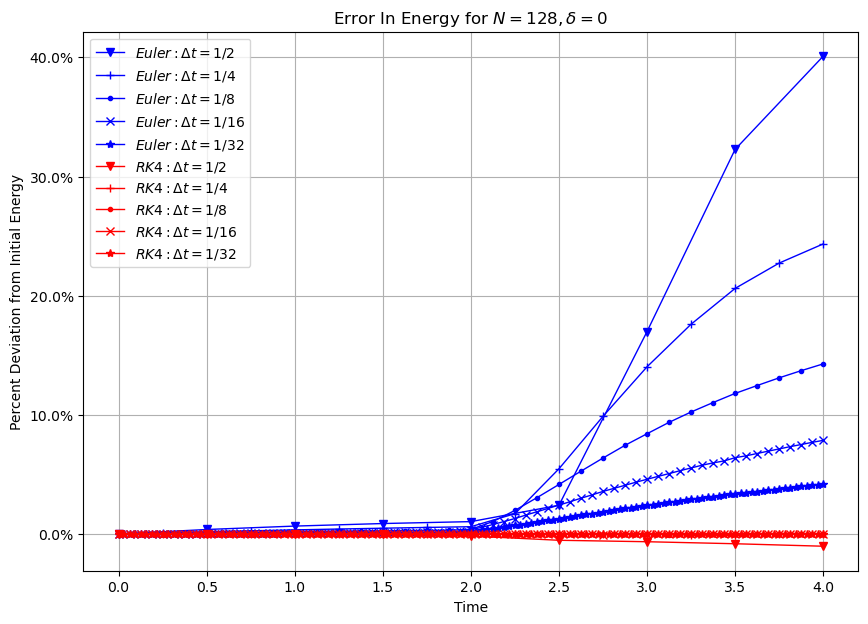

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*')) 
axs.yaxis.set_major_formatter(ticker.PercentFormatter())

for plasma in euler_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = (total_energy - total_energy[0]) / total_energy[0] * 100
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='blue', 
             linewidth = 1, label = r'$Euler: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
for plasma in rk4_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = (total_energy - total_energy[0])/ total_energy[0] * 100
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='red', 
             linewidth = 1, label = r'$RK4: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
axs.set_title("Error In Energy for $N = {}, \delta = 0$".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Percent Deviation from Initial Energy")
axs.legend()
axs.grid()

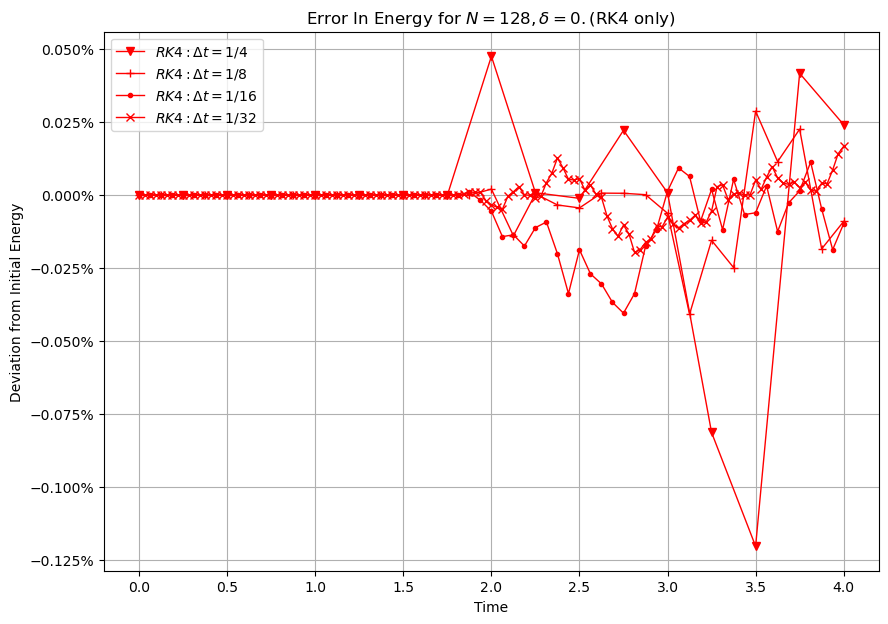

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*')) 

axs.yaxis.set_major_formatter(ticker.PercentFormatter())
    
for plasma in rk4_plasmas:
    if plasma.dt == 1/2: continue
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = (total_energy - total_energy[0]) / total_energy[0] * 100
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='red', 
             linewidth = 1, label = r'$RK4: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
axs.set_title("Error In Energy for $N = {}, \delta = 0. $(RK4 only)".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()

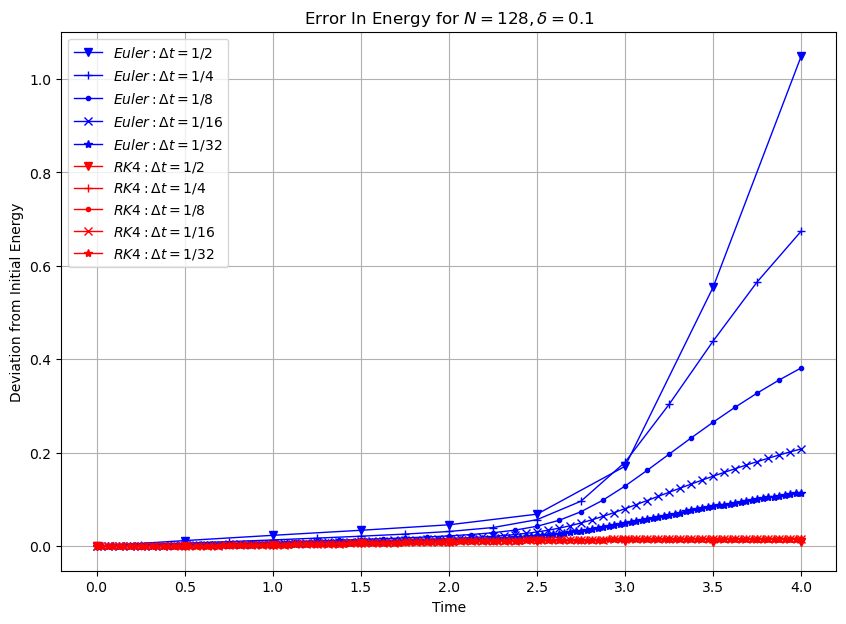

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*')) 

for plasma in reg_euler_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='blue', 
             linewidth = 1, label = r'$Euler: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
for plasma in reg_rk4_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='red', 
             linewidth = 1, label = r'$RK4: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
axs.set_title("Error In Energy for $N = {}, \delta = 0.1$".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()

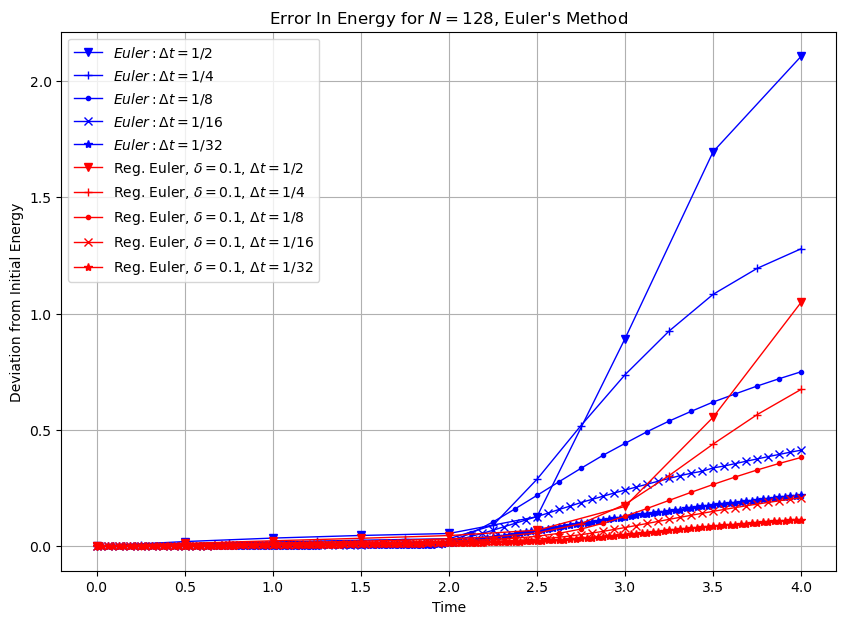

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*')) 

for plasma in euler_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='blue', 
             linewidth = 1, label = r'$Euler: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
for plasma in reg_euler_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='red', 
             linewidth = 1, label = r'Reg. Euler, $\delta = 0.1$, $\Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
axs.set_title("Error In Energy for $N = {}$, Euler's Method".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()

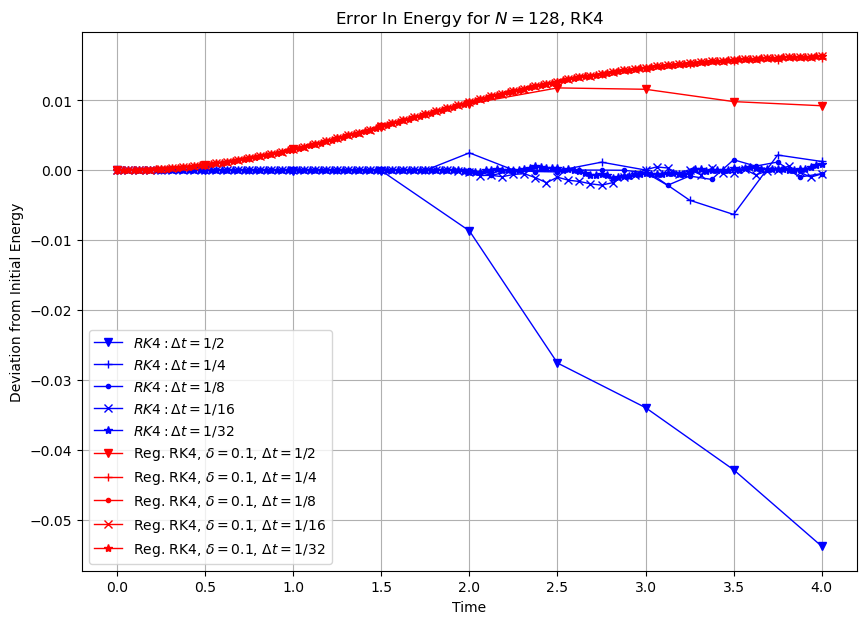

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*')) 

for plasma in rk4_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='blue', 
             linewidth = 1, label = r'$RK4: \Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
for plasma in reg_rk4_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, marker= next(marker), color='red', 
             linewidth = 1, label = r'Reg. RK4, $\delta = 0.1$, $\Delta t = 1/{}$'.format(int(1/plasma.dt)))
    
axs.set_title("Error In Energy for $N = {}$, RK4".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()

In [ ]:
dts = np.logspace(-5, -10, 6, base=2)

reg_euler_plasmas = []
reg_rk4_plasmas = []

for dt in dts:
    euler_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0.1, insertion=False, rk = False)
    rk4_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0.1, insertion=False, rk = True)
    euler_model.evolve_plasma(tmax)
    rk4_model.evolve_plasma(tmax)
    reg_euler_plasmas.append(euler_model)
    reg_rk4_plasmas.append(rk4_model)




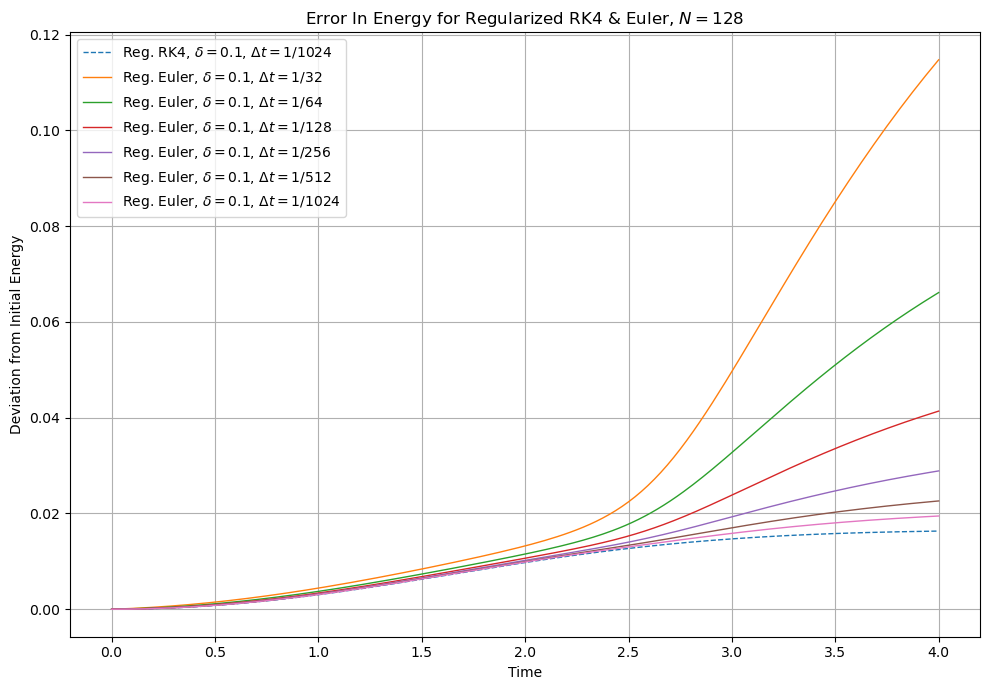

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
marker = itertools.cycle(('v', '+', '.', 'x', '*'))



rk4_total_energy = np.array(reg_rk4_plasmas[-1].Ep_hist) + np.array(reg_rk4_plasmas[-1].Ek_hist)
energy_diff = rk4_total_energy - rk4_total_energy[0]
t = np.arange(len(reg_rk4_plasmas[-1].Ep_hist))* reg_rk4_plasmas[-1].dt
axs.plot(t, energy_diff, linestyle="--",
            linewidth = 1, label = r'Reg. RK4, $\delta = 0.1$, $\Delta t = 1/{}$'.format(int(1/reg_rk4_plasmas[-1].dt)))

for plasma in reg_euler_plasmas:
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, 
             linewidth = 1, label = r'Reg. Euler, $\delta = 0.1$, $\Delta t = 1/{}$'.format(int(1/plasma.dt)))


axs.set_title("Error In Energy for Regularized RK4 & Euler, $N = {}$".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()
fig.tight_layout()

In [ ]:
deltas = 0.1 * np.logspace(0, -3, 4, base=2)
dt = 1/64
tmax = 4

diff_rk4_plasmas = []

for d in deltas:
    rk4_model = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=d, insertion=False, rk = True)
    rk4_model.evolve_plasma(tmax)
    diff_rk4_plasmas.append(rk4_model)

C:\Users\yayin\AppData\Local\Temp\ipykernel_4520\1060277952.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


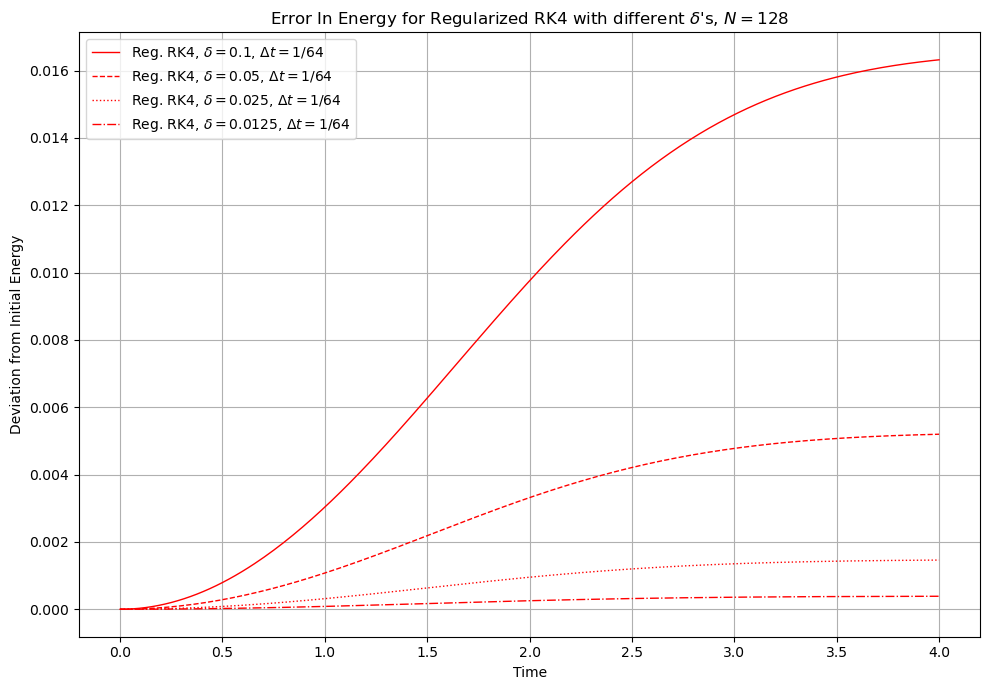

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
linestyles = itertools.cycle(('-', '--', ':', '-.'))
cmap = cm.get_cmap('Blues')
norm = plt.Normalize(0, 0.4)

for i, plasma in enumerate(diff_rk4_plasmas):
    pos = i / len(diff_rk4_plasmas)
    color = cmap(norm(pos))
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, color='red', linestyle=next(linestyles), 
             linewidth = 1, label = r'Reg. RK4, $\delta = {}$, $\Delta t = 1/{}$'.format(plasma.delta, int(1/plasma.dt)))
    
axs.set_title("Error In Energy for Regularized RK4 with different $\delta$'s, $N = {}$".format(N))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()
fig.tight_layout()

In [ ]:
Ns = np.logspace(5, 8, 4, base=2)
dt = 1/64
delta = 0.1
tmax = 4

diff_rk4_plasmas = []

for n in Ns:
    rk4_model = Plasma_Evolver(int(n), dt, epsilon_in=0.05, delta_in=delta, insertion=False, rk = True)
    rk4_model.evolve_plasma(tmax)
    diff_rk4_plasmas.append(rk4_model)

C:\Users\yayin\AppData\Local\Temp\ipykernel_4520\4110749958.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


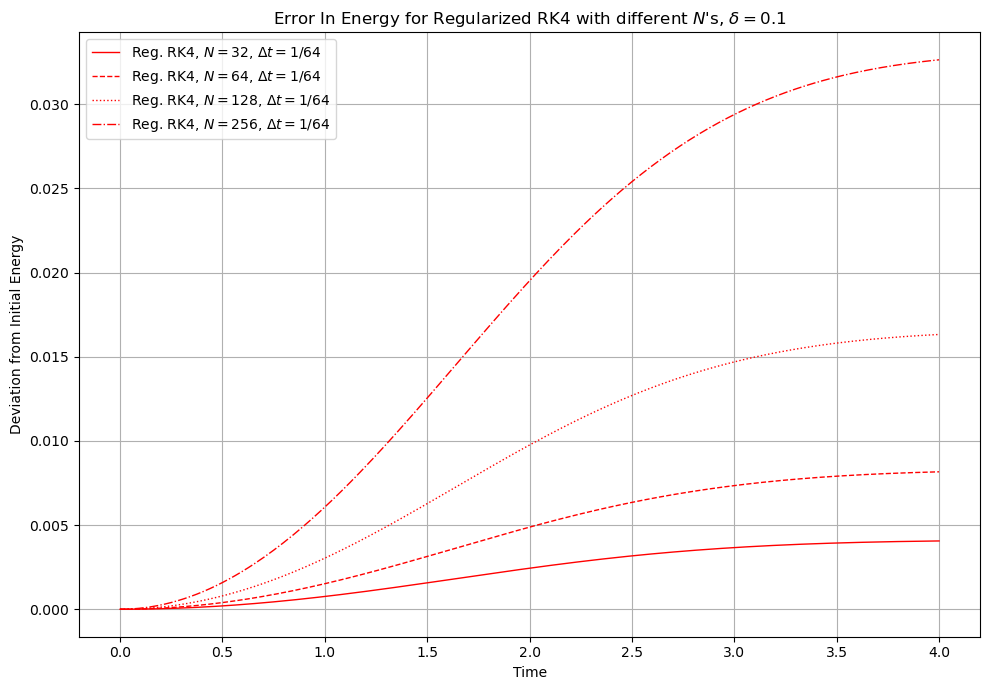

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
linestyles = itertools.cycle(('-', '--', ':', '-.'))
cmap = cm.get_cmap('Blues')
norm = plt.Normalize(0, 0.4)

for i, plasma in enumerate(diff_rk4_plasmas):
    pos = i / len(diff_rk4_plasmas)
    color = cmap(norm(pos))
    total_energy = np.array(plasma.Ep_hist) + np.array(plasma.Ek_hist)
    energy_diff = total_energy - total_energy[0]
    t = np.arange(len(plasma.Ep_hist))* plasma.dt
    axs.plot(t, energy_diff, color='red', linestyle=next(linestyles), 
             linewidth = 1, label = r'Reg. RK4, $N = {}$, $\Delta t = 1/{}$'.format(plasma.N, int(1/plasma.dt)))
    
axs.set_title("Error In Energy for Regularized RK4 with different $N$'s, $\delta = {}$".format(delta))
axs.set_xlabel("Time")
axs.set_ylabel("Deviation from Initial Energy")
axs.legend()
axs.grid()
fig.tight_layout()

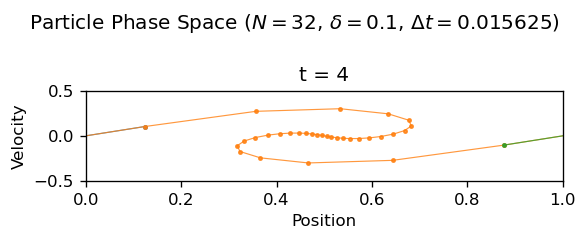

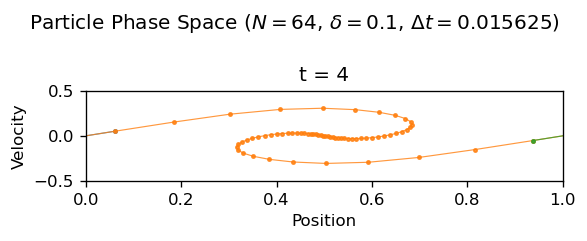

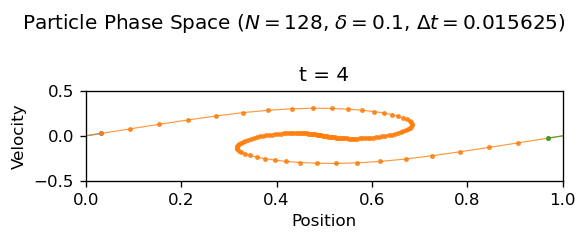

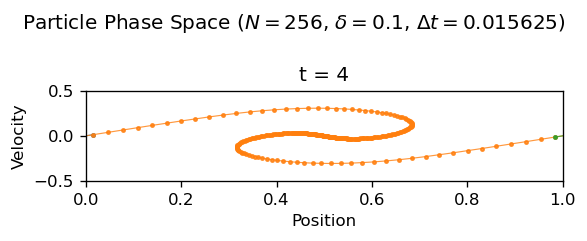

In [ ]:
for plasma in diff_rk4_plasmas:
    plasma.plot_particles((-1,),periods=1)